In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import re
import numpy
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df = pd.read_csv("sample_data/Corona_NLP.csv")
print("Number of Datapoints: {}".format(df.shape[0]))
df.head()

FileNotFoundError: ignored

In [ ]:
# Quick way of cleaning up dataframe due to a formating error, results in 90 datapoints lost of 3798, better methods would require more work
# 4000 datapoints is pretty small, may want to go with different dataset anyways for better accuracy

# Drop all rows with data in its 7th column (all rows with formatting errors)
df.drop(df[df['Unnamed: 6'] == df['Unnamed: 6']].index, inplace=True)
# Drop all unnamed rows
df.drop(df.columns[[6,7,8,9,10]], axis=1, inplace=True)
# Save to csv
df.to_csv("sample_data/Corona_modified.csv")
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
# Turn sentiment result into numerical values for easy analysis
# Will have to modify this for better model implementation i.e one hot encode
def numerize(result):
    if(result == "Extremely Negative"):
        return -2
    elif result == "Negative":
        return -1
    elif result == "Neutral":
        return 0
    elif result == "Positive":
        return 1
    return 2

df["Sentiment_Numerical"] = df.apply(lambda row: numerize(row["Sentiment"]), axis=1)
df.head()


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_Numerical
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,-2
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,1
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,2
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,-1
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,0


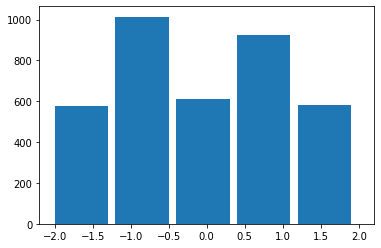

In [ ]:
# Analyzing distribution of data
arr = df["Sentiment_Numerical"].to_numpy()
binNum = 5
# Plot histogram showing the distribution of data
plt.hist(arr, binNum, width=0.7)
plt.show()
# Overall dataset is pretty well distributed, contains slight negative scew 

In [ ]:
# Data cleaning

# Initialize stop words to be removed
stopWrds = stopwords.words('english')

# Clean text either through stemming or lemmatizing
# Stemming is faster but can lead to two words with different meanings being treated the same
# Lemmatizing may be more accurate but takes longer to train due to higher word count
lemmer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()


# Removes all special characters from each word and all words in stop words + removes http links
# Additionally stems or lemmatizes each word to a core definition
def cleanTextStem(text):
    return " ".join([stemmer.stem((re.sub("[^a-z]+", ' ', word.lower()))) for word in text.split() if word not in stopWrds and 'https' not in word])
    
# cleans words but uses a lemmatizer instead of a porter stemmer
def cleanTextLemm(text):
    return " ".join([lemmer.lemmatize((re.sub("[^a-z]+", ' ', word.lower()))) for word in text.split() if word not in stopWrds and 'https' not in word])

# Clean text and store on dataframe
df["CleanedTweetsStemmed"] = df.apply(lambda row: cleanTextStem(row["OriginalTweet"]), axis=1)
df["CleanedTweetsLemmatized"] = df.apply(lambda row: cleanTextLemm(row["OriginalTweet"]), axis=1)

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_Numerical,CleanedTweetsStemmed,CleanedTweetsLemmatized
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,-2,trending new yorker encount empti supermarket...,trending new yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,1,when i find hand sanit fred meyer i turn ama...,when i find hand sanitizer fred meyer i turne...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,2,find protect love one coronavirus,find protect loved one coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,-1,panic buy hit newyork citi anxiou shopper st...,panic buying hit newyork city anxious shoppe...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,0,toiletpap dunnypap coronaviru coronavirusa...,toiletpaper dunnypaper coronavirus coronav...


In [ ]:
# Save data frame
df.to_csv("Corona_NLP_Cleaned.csv", index=False)

In [ ]:
# Prepare data for use with chosen model
# TODO: Implement one hot encoding for y values
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Putting this in a function to easily call it from external files
# Count vectorize = number of occurences of word, tfidf = word frequency
def vectorize(cleanText, useCountVect=True):
    # Vectorize text either using a count vectorizer or tfidf
    vect = CountVectorizer() if useCountVect else TfidfVectorizer()
    return vect.fit_transform(cleanText)


X = vectorize(df["CleanedTweetsStemmed"].tolist())
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
